<a href="https://colab.research.google.com/github/cmwema/djangoMLAPI/blob/main/loanApprovalPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense

2024-04-01 01:21:45.846936: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 01:21:45.852821: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 01:21:45.936801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 01:21:47.888996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load data
- In this case, the dataset is uploaded from local machine.

In [2]:
# from google.colab import files


# uploaded = files.upload()

In [16]:
# import io
# for filename, content in uploaded.items():
#     df = pd.read_csv(io.BytesIO(content))
df = pd.read_csv('bankloan.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [17]:
df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0.0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3.0,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1.0,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2.0,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0.0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [18]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [19]:
df.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,599.000000,614.000000,614.000000,592.000000,600.00000,564.000000
mean,0.762938,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,1.015216,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,0.000000,150.000000,0.000000,9.000000,12.00000,0.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,0.000000,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,2.000000,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,3.000000,81000.000000,41667.000000,700.000000,480.00000,1.000000


# Preprocessing

In [20]:
df = df.dropna()
df.isna().any()
df = df.drop('Loan_ID', axis=1)
df['LoanAmount'] = (df['LoanAmount']*1000).astype(int)
Counter(df['Loan_Status'])

Counter({'Y': 332, 'N': 148})

In [21]:
# % of yes
Counter(df['Loan_Status'])['Y']/df['Loan_Status'].size

0.6916666666666667

In [22]:
Counter(df['Property_Area'])

Counter({'Semiurban': 191, 'Urban': 150, 'Rural': 139})

In [23]:
df['Property_Area'] = df['Property_Area'].map({'Urban': 1, 'Rural': 0, 'Semiurban': 0.5})
df['Education'] = (df['Education'] == "Graduate")
df['Married'] = (df['Married'] == "Yes")
df['Gender'] = (df['Gender'] == "Male")
df['Self_Employed'] = (df['Self_Employed'] == "Yes")
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,True,True,1.0,True,False,4583,1508.0,128000,360.0,1.0,0.0,N
2,True,True,0.0,True,True,3000,0.0,66000,360.0,1.0,1.0,Y
3,True,True,0.0,False,False,2583,2358.0,120000,360.0,1.0,1.0,Y
4,True,False,0.0,True,False,6000,0.0,141000,360.0,1.0,1.0,Y
5,True,True,2.0,True,True,5417,4196.0,267000,360.0,1.0,1.0,Y


In [24]:
# df = df.drop("Gender", axis=1)
# df = df.drop("Self_Employed", axis=1)
# df.head()

In [25]:
pre_y = df['Loan_Status'].map(dict(Y=1, N=0))
pre_x = df.drop('Loan_Status', axis=1)

In [26]:
pre_x.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
1,True,True,1.0,True,False,4583,1508.0,128000,360.0,1.0,0.0
2,True,True,0.0,True,True,3000,0.0,66000,360.0,1.0,1.0
3,True,True,0.0,False,False,2583,2358.0,120000,360.0,1.0,1.0
4,True,False,0.0,True,False,6000,0.0,141000,360.0,1.0,1.0
5,True,True,2.0,True,True,5417,4196.0,267000,360.0,1.0,1.0


In [27]:
pre_y.head()

1    0
2    1
3    1
4    1
5    1
Name: Loan_Status, dtype: int64

In [28]:
smote = SMOTE(sampling_strategy='minority')
x1, y = smote.fit_resample(pre_x, pre_y)
sc = MinMaxScaler()
x = sc.fit_transform(x1)

In [29]:
print(f'Resampled dataset shape {Counter(y)}')

Resampled dataset shape Counter({0: 332, 1: 332})


In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# The Classifier Model
- Sequential Neural Network Model is used.

In [31]:
# Define the classifier model
classifier = Sequential()

# Add layers to the model
classifier.add(Dense(150, activation='relu', kernel_initializer='random_normal', input_shape=(X_train.shape[1],)))
classifier.add(Dense(800, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

# Compile the model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
classifier.fit(X_train, y_train, batch_size=10, epochs=100)

# Evaluate the model on the test data
eval_model = classifier.evaluate(X_test, y_test)
eval_model

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5395 - loss: 0.6887
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6606 - loss: 0.6718
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6285 - loss: 0.6531
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6609 - loss: 0.5930
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7042 - loss: 0.5318
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7441 - loss: 0.5399
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7031 - loss: 0.5819
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7475 - loss: 0.5130
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7304 - loss: 0.5341
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7637 - loss: 0.4930
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7615 - loss: 0.5050
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy

[1.3014644384384155, 0.7218044996261597]

In [38]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.49) # over 0.5 loan is approved otherwise it is rejected

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


# Confusion Matrix

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

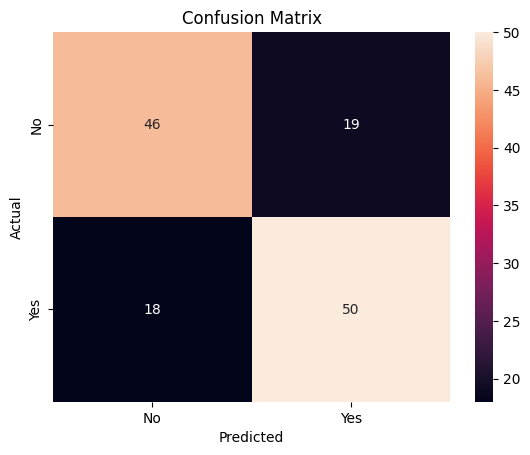

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["No", "Yes"])
ax.yaxis.set_ticklabels(["No", "Yes"])

In [51]:
# Support vector Machine model
from sklearn.svm import SVC

svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
svm.fit(X_train, y_train)

SVC(gamma=0.5)

In [52]:
y_pred = svm.predict(X_test)
y_pred = (y_pred > 0.9)

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

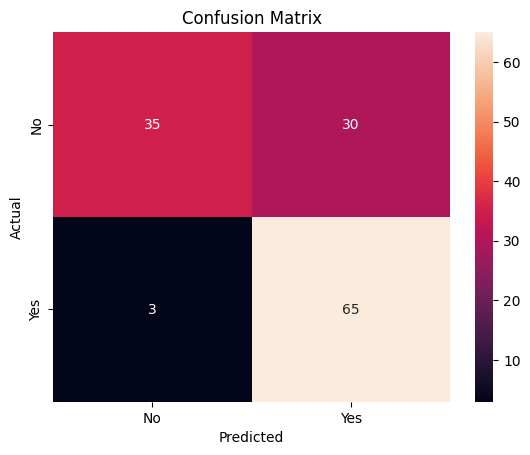

In [53]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["No", "Yes"])
ax.yaxis.set_ticklabels(["No", "Yes"])

# Save the model

In [21]:
classifier.save("loan_model.keras")